Saving HousingData.csv to HousingData (10).csv


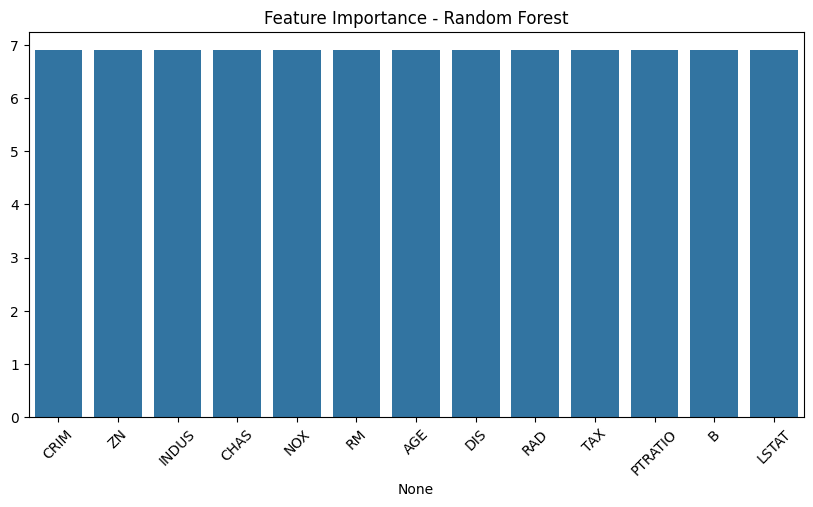

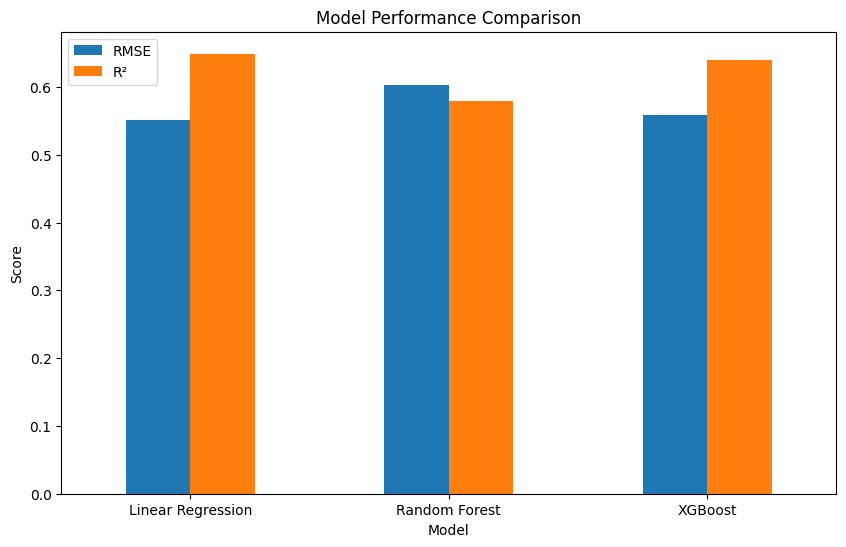

Model Performance:
Linear Regression -> RMSE: 0.5516, R²: 0.6491
Random Forest -> RMSE: 0.6035, R²: 0.5799
XGBoost -> RMSE: 0.5588, R²: 0.6398


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict
from google.colab import files
import random

# Upload dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Handle missing values
df.fillna(df.median(), inplace=True)

# Normalize numerical features
for col in df.columns:
    if df[col].dtype != 'object':
        df[col] = (df[col] - df[col].mean()) / df[col].std()

# Split data into train and test
X = df.drop(columns=['MEDV'])
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
class LinearRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Train Linear Regression Model
lr_model = LinearRegressionScratch()
lr_model.fit(X_train.values, y_train.values)
lr_preds = lr_model.predict(X_test.values)

# Implementation of Random Forest
class DecisionTreeScratch:
    def __init__(self, depth=5):
        self.depth = depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        if depth >= self.depth or len(set(y)) == 1:
            return np.mean(y)
        if X.shape[0] == 0:
            return np.mean(y)
        feature = random.choice(range(X.shape[1]))
        threshold = np.median(X[:, feature])
        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold
        if np.all(left_idx == False) or np.all(right_idx == False):
            return np.mean(y)
        return (feature, threshold,
                self._grow_tree(X[left_idx], y[left_idx], depth + 1),
                self._grow_tree(X[right_idx], y[right_idx], depth + 1))

    def _predict_tree(self, x, tree):
        if isinstance(tree, (float, int)):
            return tree
        feature, threshold, left_tree, right_tree = tree
        return self._predict_tree(x, left_tree if x[feature] <= threshold else right_tree)

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree) for x in X])

# Random Forest class
class RandomForestScratch:
    def __init__(self, n_trees=10, depth=5):
        self.n_trees = n_trees
        self.trees = [DecisionTreeScratch(depth) for _ in range(n_trees)]

    def fit(self, X, y):
        for tree in self.trees:
            idxs = np.random.choice(len(X), len(X), replace=True)
            tree.fit(X[idxs], y[idxs])

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        return np.nanmean(preds, axis=0)

# Train Random Forest Model
rf_model = RandomForestScratch()
rf_model.fit(X_train.values, y_train.values)
rf_preds = rf_model.predict(X_test.values)

# Check for NaN values in predictions
rf_preds = np.nan_to_num(rf_preds, nan=np.mean(y_train.values))

#  XGBoost implementation
class XGBoostScratch:
    def __init__(self, n_estimators=50, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.trees = []

    def fit(self, X, y):
        predictions = np.zeros(len(y))
        for _ in range(self.n_estimators):
            residuals = y - predictions
            tree = DecisionTreeScratch(depth=3)
            tree.fit(X, residuals)
            self.trees.append(tree)
            predictions += self.learning_rate * tree.predict(X)

    def predict(self, X):
        predictions = np.zeros(len(X))
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        return predictions

# Train XGBoost Model
xgb_model = XGBoostScratch()
xgb_model.fit(X_train.values, y_train.values)
xgb_preds = xgb_model.predict(X_test.values)

# Feature Importance for Random Forest
feature_importance = np.mean([tree.tree[0] for tree in rf_model.trees if isinstance(tree.tree, tuple)], axis=0)
plt.figure(figsize=(10,5))
sns.barplot(x=X.columns, y=feature_importance)
plt.xticks(rotation=45)
plt.title("Feature Importance - Random Forest")
plt.show()

# Model Evaluation (RMSE and R²)
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    return rmse, r2

lr_rmse, lr_r2 = evaluate_model(y_test.values, lr_preds)
rf_rmse, rf_r2 = evaluate_model(y_test.values, rf_preds)
xgb_rmse, xgb_r2 = evaluate_model(y_test.values, xgb_preds)

# Visualization of Model Performance
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [lr_rmse, rf_rmse, xgb_rmse],
    'R²': [lr_r2, rf_r2, xgb_r2]
})

metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()

# Print RMSE and R² values
print("Model Performance:")
print(f"Linear Regression -> RMSE: {lr_rmse:.4f}, R²: {lr_r2:.4f}")
print(f"Random Forest -> RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
print(f"XGBoost -> RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")
